In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
!pip install catboost
import pandas as pd
import numpy as np
import os
import seaborn as sns 
from scipy import stats
from scipy.stats import norm,skew
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import xgboost as xgb
import catboost as catb
import operator
import time
import ast
from collections import Counter
import itertools
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#!pip install networkx
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn import model_selection
from sklearn import linear_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

matplotlib.style.use('fivethirtyeight')

In [0]:
import pandas as pd
#https://drive.google.com/open?id=1bOQiIBne8aPCg6hLKeiHLTklS2mnWdII
#https://drive.google.com/open?id=1Gb6aE1lJn3jukR0_DKfhwjj-AnP9c6XS
test1_id = '1TT3Dwx4kUImqdFacTlbfb9Bl4_N3Q_gM'
train_id = '1TOrFE2hrMC_EbQ60zQEPs49_G5p-Gr-w'
test2_id = '1U9AjUP6ZK486xf0LbCvt2SkH_vUv0-L3'

down1 = drive.CreateFile({'id':train_id})
down2 = drive.CreateFile({'id':test1_id})
#down3 = drive.CreateFile({'id':test2_id})

down1.GetContentFile('train.csv')
down2.GetContentFile('test.csv')
#down3.GetContentFile('test2.csv')

trainDF = pd.read_csv('train.csv')
testDF = pd.read_csv('test.csv')
#test2DF = pd.read_csv('test2.csv')

print(trainDF.shape)
print(testDF.shape)
#print(test2DF.shape)

trainDF.head()

(404290, 6)
(2345796, 3)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
trainDF.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


##Create dictionary and extract Bag of Words features from each question

###create dictionary and extract BOW features from questions

In [0]:
featureExtractionStartTime = time.time()
trainDF = trainDF.dropna(how="any").reset_index(drop=True)

maxNumFeatures = 500
BagOfWordsExtractor = CountVectorizer(max_df=0.7, min_df=1000, max_features=maxNumFeatures, 
                                      analyzer='word', ngram_range=(1,2), 
                                      binary=True, lowercase=True)

BagOfWordsExtractor.fit(pd.concat((trainDF.loc[:,'question1'],trainDF.loc[:,'question2'])).unique())


CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.7, max_features=500, min_df=1000,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
trainQuestion1_BOW_rep = BagOfWordsExtractor.transform(trainDF.loc[:,'question1'])
trainQuestion2_BOW_rep = BagOfWordsExtractor.transform(trainDF.loc[:,'question2'])
lables = np.array(trainDF.loc[:,'is_duplicate'])
featureExtractionDurationInMinutes = (time.time()-featureExtractionStartTime)/60.0
print("feature extraction took %.2f minutes" % (featureExtractionDurationInMinutes))


feature extraction took 0.72 minutes


##Cross Validation

In [0]:
crossValidationStartTime = time.time()
numCVSplits = 8
numSplitsToBreakAfter = 5
X = -(trainQuestion1_BOW_rep != trainQuestion2_BOW_rep).astype(int)
y = lables
logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag')
logRegAccuracy = []
logRegLogLoss = []
logRegAUC = []
print('---------------------------------------------')
stratifiedCV = model_selection.StratifiedKFold(n_splits=numCVSplits, random_state=2)
for k, (trainInds, validInds) in enumerate(stratifiedCV.split(X, y)):
    foldTrainingStartTime = time.time()

    X_train_cv = X[trainInds,:]
    X_valid_cv = X[validInds,:]

    y_train_cv = y[trainInds]
    y_valid_cv = y[validInds]

    logisticRegressor.fit(X_train_cv, y_train_cv)

    y_train_hat =  logisticRegressor.predict_proba(X_train_cv)[:,1]
    y_valid_hat =  logisticRegressor.predict_proba(X_valid_cv)[:,1]

    logRegAccuracy.append(accuracy_score(y_valid_cv, y_valid_hat > 0.5))
    logRegLogLoss.append(log_loss(y_valid_cv, y_valid_hat))
    logRegAUC.append(roc_auc_score(y_valid_cv, y_valid_hat))
    
    foldTrainingDurationInMinutes = (time.time()-foldTrainingStartTime)/60.0
    print('fold %d took %.2f minutes: accuracy = %.3f, log loss = %.4f, AUC = %.3f' % (k+1,
             foldTrainingDurationInMinutes, logRegAccuracy[-1],logRegLogLoss[-1],logRegAUC[-1]))

    if (k+1) >= numSplitsToBreakAfter:
        break


crossValidationDurationInMinutes = (time.time()-crossValidationStartTime)/60.0

print('---------------------------------------------')
print('cross validation took %.2f minutes' % (crossValidationDurationInMinutes))
print('mean CV: accuracy = %.3f, log loss = %.4f, AUC = %.3f' % (np.array(logRegAccuracy).mean(),
                                                                 np.array(logRegLogLoss).mean(),
                                                                 np.array(logRegAUC).mean()))
print('---------------------------------------------')


---------------------------------------------
fold 1 took 0.08 minutes: accuracy = 0.671, log loss = 0.5661, AUC = 0.737
fold 2 took 0.08 minutes: accuracy = 0.673, log loss = 0.5641, AUC = 0.739
fold 3 took 0.08 minutes: accuracy = 0.671, log loss = 0.5669, AUC = 0.736
fold 4 took 0.08 minutes: accuracy = 0.670, log loss = 0.5669, AUC = 0.735
fold 5 took 0.08 minutes: accuracy = 0.672, log loss = 0.5660, AUC = 0.738
---------------------------------------------
cross validation took 0.40 minutes
mean CV: accuracy = 0.671, log loss = 0.5660, AUC = 0.737
---------------------------------------------


[Text(0, 0, 'song'),
 Text(0, 0, 'girlfriend'),
 Text(0, 0, 'trump'),
 Text(0, 0, 'download'),
 Text(0, 0, 'bank'),
 Text(0, 0, 'parents'),
 Text(0, 0, 'review'),
 Text(0, 0, 'white'),
 Text(0, 0, 'car'),
 Text(0, 0, 'cost'),
 Text(0, 0, 'hair'),
 Text(0, 0, 'non'),
 Text(0, 0, 'water'),
 Text(0, 0, 'pay'),
 Text(0, 0, 'social'),
 Text(0, 0, 'com'),
 Text(0, 0, 'word'),
 Text(0, 0, 'windows'),
 Text(0, 0, 'music'),
 Text(0, 0, 'god'),
 Text(0, 0, 'android'),
 Text(0, 0, 'how many'),
 Text(0, 0, 'card'),
 Text(0, 0, 'mechanical'),
 Text(0, 0, 'facebook'),
 Text(0, 0, 'china'),
 Text(0, 0, 'instagram'),
 Text(0, 0, 'java'),
 Text(0, 0, 'youtube'),
 Text(0, 0, 'delhi')]

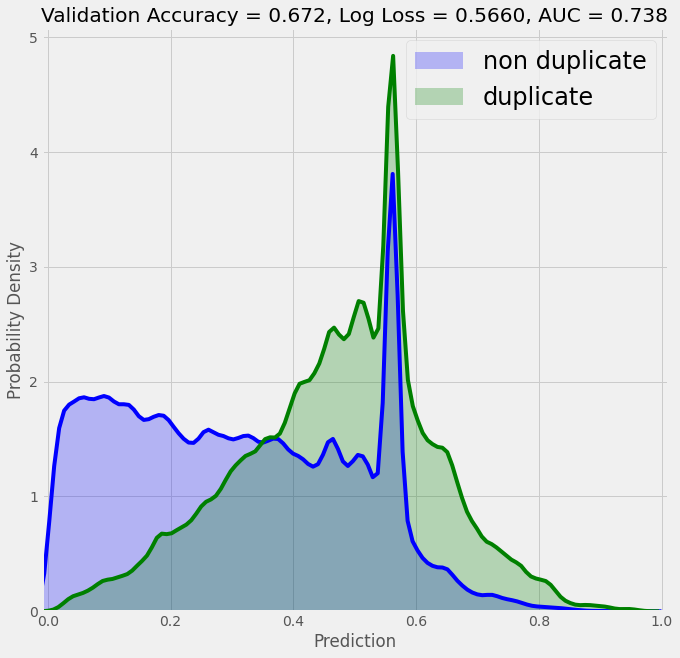

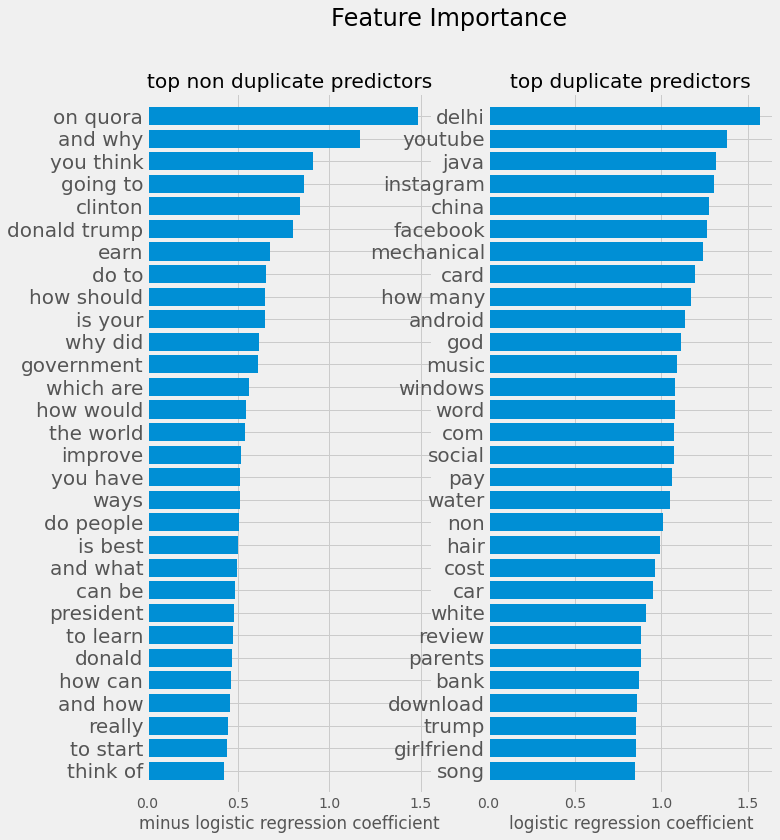

In [0]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.figure(); 
sns.kdeplot(y_valid_hat[y_valid_cv==0], shade=True, color="b", bw=0.01)
sns.kdeplot(y_valid_hat[y_valid_cv==1], shade=True, color="g", bw=0.01)
plt.legend(['non duplicate','duplicate'],fontsize=24)
plt.title('Validation Accuracy = %.3f, Log Loss = %.4f, AUC = %.3f' %(logRegAccuracy[-1],
                                                                      logRegLogLoss[-1],
                                                                      logRegAUC[-1]))
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)


numFeaturesToShow = 30

sortedCoeffients = np.sort(logisticRegressor.coef_)[0]
featureNames = BagOfWordsExtractor.get_feature_names()
sortedFeatureNames = [featureNames[x] for x in list(np.argsort(logisticRegressor.coef_)[0])]

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,12)

plt.figure()
plt.suptitle('Feature Importance',fontsize=24)
ax = plt.subplot(1,2,1); plt.title('top non duplicate predictors'); 
plt.xlabel('minus logistic regression coefficient')
ax.barh(range(numFeaturesToShow), -sortedCoeffients[:numFeaturesToShow][::-1], align='center'); 
plt.ylim(-1,numFeaturesToShow); ax.set_yticks(range(numFeaturesToShow)); 
ax.set_yticklabels(sortedFeatureNames[:numFeaturesToShow][::-1],fontsize=20)

ax = plt.subplot(1,2,2); plt.title('top duplicate predictors'); 
plt.xlabel('logistic regression coefficient')
ax.barh(range(numFeaturesToShow), sortedCoeffients[-numFeaturesToShow:], align='center'); 
plt.ylim(-1,numFeaturesToShow); ax.set_yticks(range(numFeaturesToShow)); 
ax.set_yticklabels(sortedFeatureNames[-numFeaturesToShow:],fontsize=20)

## Train on the full training data

In [0]:
trainingStartTime = time.time()

logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag', 
                                                    class_weight={1: 0.46, 0: 1.32})
logisticRegressor.fit(X, y)

trainingDurationInMinutes = (time.time()-trainingStartTime)/60.0
print('full training took %.2f minutes' % (trainingDurationInMinutes))


full training took 0.09 minutes


In [0]:
testPredictionStartTime = time.time()

test1DF = pd.read_csv('test.csv')
test2DF = pd.read_csv('test2.csv')
print(test1DF.shape)
print(test2DF.shape)

(2345796, 3)
(3563475, 3)


In [0]:
testDF.loc[testDF['question1'].isnull(),['question1','question2']] = 'random empty question'
testDF.loc[testDF['question2'].isnull(),['question1','question2']] = 'random empty question'

testQuestion1_BOW_rep = BagOfWordsExtractor.transform(testDF.loc[:,'question1'])
testQuestion2_BOW_rep = BagOfWordsExtractor.transform(testDF.loc[:,'question2'])


In [0]:
X_test = -(testQuestion1_BOW_rep != testQuestion2_BOW_rep).astype(int)
X_test.shape

(2345796, 500)

predicting on test took 3.85 minutes


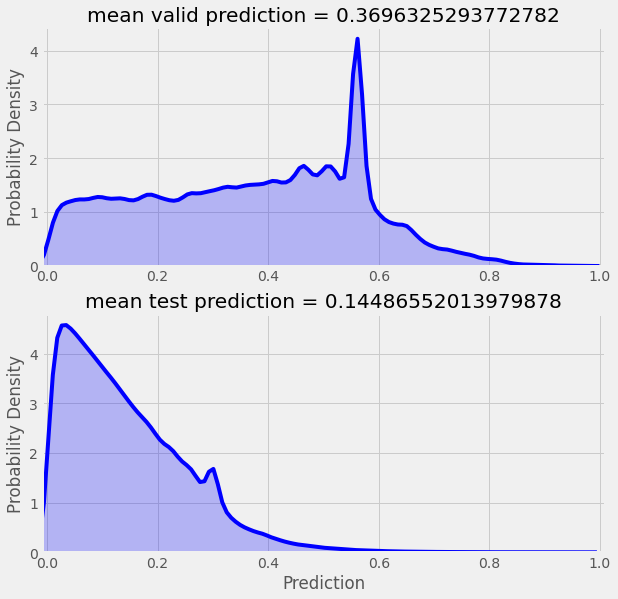

In [0]:
seperators= [750000,1500000]
testPredictions1 = logisticRegressor.predict_proba(X_test[:seperators[0],:])[:,1]
testPredictions2 = logisticRegressor.predict_proba(X_test[seperators[0]:seperators[1],:])[:,1]
testPredictions3 = logisticRegressor.predict_proba(X_test[seperators[1]:,:])[:,1]
testPredictions = np.hstack((testPredictions1,testPredictions2,testPredictions3))

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9,9)

plt.figure(); 
plt.subplot(2,1,1); sns.kdeplot(y_valid_hat, shade=True, color="b", bw=0.01); 
plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)
plt.title('mean valid prediction = ' + str(np.mean(y_valid_hat)))
plt.subplot(2,1,2); sns.kdeplot(testPredictions, shade=True, color="b", bw=0.01);
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)
plt.title('mean test prediction = ' + str(np.mean(testPredictions)))

testPredictionDurationInMinutes = (time.time()-testPredictionStartTime)/60.0
print('predicting on test took %.2f minutes' % (testPredictionDurationInMinutes))


In [0]:
submissionName = 'shallowBenchmark'

submission = pd.DataFrame()
submission['test_id'] = testDF['test_id']
submission['is_duplicate'] = testPredictions
submission.to_csv(submissionName + '.csv', index=False)

In [0]:
from google.colab import files
files.download('shallowBenchmark.csv')

In [0]:
submission.shape

#Second Solution

In [0]:
import os
os.listdir('')

In [0]:
pwd